In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numpy as onp
import jax
import jax.random as jr
import jax.numpy as jnp
import pylab as plt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy

# local imports
import sys
sys.path.append('../')

from util.ellipse import plot_ellipse, create_ellipse
from dais.DAIS import DAIS as DAIS
from dais.OAIS import OAIS as OAIS
from dais.AMIS import AMIS as AMIS


from dais.proba.density import LogDensityGeneral
from dais.proba.student import Student
from dais.variational.double_stochastic import DoubleStochastic

In [2]:
# initialize random number generator
key = jr.key(0)

### Setup toy targets

In [3]:
# set up the banana-shaped synthetic distribution
def U_scalar_banana(x):
    """
    The log posterior, up to a constant
    
    This is the banana-shaped synthetic distribution from Table 1 of
    Ruiz and Titsias (2019).
    """
    Sigma = jnp.array([[1, 0.9], [0.9, 1]])
    Sigma_inv = jnp.linalg.inv(Sigma)
    m = jnp.array([x[0], x[1] + x[0]*x[0] + 1])
    return -0.5 * m @ Sigma_inv @ m

# create the log density object
logdensity_banana = LogDensityGeneral(logdensity=U_scalar_banana, dim=2)


In [4]:
# set up the mixture of Gaussians synthetic distribution
weight = np.array([0.3, 0.8])
mean_mixture = np.array([0.8, -2.0])
n_cmpnt = len(weight)

Sigma_onp = onp.array([
    [[1.0, 0.8], [0.8, 1.0]],
    [[1.0, -0.6], [-0.6, 1.0]],
    ])

DIM = 2
Sigma_inv_onp = onp.empty((n_cmpnt, DIM, DIM))

for i in range(n_cmpnt):
    Sigma_inv_onp[i, :, :] = onp.linalg.inv(Sigma_onp[i, :, :])

Sigma_mixture = jnp.asarray(Sigma_onp)
Sigma_inv_mixture = np.asarray(Sigma_inv_onp)
weight_det_mixture = weight / np.sqrt(np.array([np.linalg.det(Sigma_mixture[i, :, :]) for i in range(n_cmpnt)]))

def U_scalar_mixture(x):
    """
    The log posterior, up to a constant
    
    This is the synthetic mixture distribution from Table 1 of
    Ruiz and Titsias (2019, http://proceedings.mlr.press/v97/ruiz19a.html).
    """
    m = jnp.array([x - mean_mixture[i] for i in range(n_cmpnt)])
    
    return jnp.log(jnp.sum(weight_det_mixture * jnp.array([
        jnp.exp(-0.5 * m[i, :] @ Sigma_inv_mixture[i, :, :] @ m[i, :])
        for i in range(n_cmpnt)
    ])))

# create the log density object
logdensity_mixture = LogDensityGeneral(logdensity=U_scalar_mixture, dim=2)

### Basic Adaptive Importance Sampling (BAIS)

In [5]:
def basic_adaptive_IS(
                logdensity,     # log density object
                n_samples,      # number of samples
                n_iter,         # number of iterations
                key,            # random key
                ):
    """ Basic adaptive importance sampling """
    DIM = logdensity.dim
    mu_IS = jnp.zeros(DIM)
    cov_IS = jnp.eye(DIM)

    for IS_iter in range(n_iter):
        # importance sampling
        student = Student(mu=mu_IS, cov=cov_IS, deg=3)
        
        key, key_ = jr.split(key)
        samples_student = student.sample(key=key_, n_samples=n_samples)
        log_weights = logdensity.batch(x_batch=samples_student) - student.batch(x_batch=samples_student)
        
        # importance weights
        log_weights = log_weights - jnp.max(log_weights)
        weights = jnp.exp(log_weights)
        weights = weights / jnp.sum(weights)
        
        # effective sample size
        ESS = 1 / jnp.sum(weights ** 2)
        ESS_normalized = ESS / n_samples

        # posterior mean
        mu_IS = jnp.sum(samples_student * weights[:, None], axis=0)

        # posterior covariance
        Sigma_IS= jnp.sum(weights[:, None, None] * (samples_student - mu_IS)[:, :, None] * (samples_student - mu_IS)[:, None, :], axis=0)

        # print
        print(f"Iteration {IS_iter} \t ESS_normalized = {ESS_normalized:.3f}")

    mu_IS
    Sigma_IS
    AIS_dict = {
        "mu": mu_IS,
        "Sigma": Sigma_IS
    }
    return AIS_dict

### Helper plotting functions

In [6]:
def display_DAIS_trajectory(dais_output):
    fig, ax_left = plt.subplots(figsize=(6,4))
    ax_right = ax_left.twinx()

    # display gamma
    plot_eps = ax_left.plot(dais_output["eps_traj"], "-^", lw=1, color='blue', label=r"$\gamma_T$")
    ax_left.plot([0, len(dais_output["eps_traj"])], [1,1], "--", lw=2, color='blue')
    ax_left.set_ylim(0,1.45)
    ax_left.set_xlim(left=0)
    ax_left.set_ylabel(r"$\gamma_t$", fontsize=15, color="blue")
    ax_left.set_xlabel("DAIS Iteration", fontsize=15)
    ax_left.grid(True, which="major")

    # display -ELBO
    plot_elbo = ax_right.plot(-np.array(dais_output["elbo_traj"]),
                    color='red', label="-ELBO", lw=3)
    ax_right.set_ylabel("-ELBO", fontsize=15, color="red")

    # added these three lines
    lns = plot_eps + plot_elbo
    labs = [l.get_label() for l in lns]
    ax_left.legend(lns, labs, loc=1, fontsize=15)

    # added these three lines
    lns = plot_eps + plot_elbo
    labs = [l.get_label() for l in lns]
    ax_left.legend(lns, labs, loc=1, fontsize=15)

In [7]:
def display_statistics(
        *,
        logdensity,
        dais_output = None,
        DSVI_mu = None,
        DSVI_Sigma = None,
        OAIS_mu = None,
        OAIS_Sigma = None,
        AMIS_mu = None,
        AMIS_Sigma = None,
        mu_exact = None,
        Sigma_exact = None,
        xlims = (-1,1),
        ylims = (-1,1),
        ):

        # 2D plot of the target
        xmin, xmax = xlims
        ymin, ymax = ylims
        xarr = jnp.linspace(xmin, xmax, 100)
        yarr = jnp.linspace(ymin, ymax, 100)
        X, Y = jnp.meshgrid(xarr, yarr)
        inputs = jnp.stack([X, Y], axis=-1)
        Z = logdensity.batch(x_batch=inputs.reshape(-1, 2)).reshape(*X.shape)

        plt.imshow(-np.exp(Z),
                interpolation='bilinear',
                origin='lower',
                cmap = "gray",
                extent=(xmin, xmax, ymin, ymax))

        ax = plt.gca()

        # Ellipse: Exact
        if mu_exact is not None and Sigma_exact is not None:
                ellipse = create_ellipse(mean = mu_exact,
                                        covariance = Sigma_exact,
                                        color="gray",
                                        linestyle=(0, (1, 1)), lw=5)
                ax.add_artist(ellipse)
                ax.scatter(mu_exact[0], mu_exact[1], color="gray", s=20, zorder=10, label="Exact")

        # Ellipse: DAIS
        if dais_output is not None:
                ellipse = create_ellipse(mean = dais_output['mu'],
                                        covariance = dais_output['cov'],
                                        color="blue",
                                        linestyle="-")
                ax.add_artist(ellipse)
                ax.scatter(dais_output['mu'][0], dais_output['mu'][1], color="blue", s=20, zorder=10, label="DAIS")

        # Ellipse: DSVI
        if DSVI_mu is not None and DSVI_Sigma is not None:
                ellipse = create_ellipse(mean = DSVI_mu,
                                        covariance = DSVI_Sigma,
                                        color="red",
                                        linestyle="--")
                ax.add_artist(ellipse)
                ax.scatter(DSVI_mu[0], DSVI_mu[1], color="red", s=20, zorder=10, label="DSVI")

        # Ellipse: OAIS
        if OAIS_mu is not None and OAIS_Sigma is not None:
                ellipse = create_ellipse(mean = OAIS_mu,
                                        covariance = OAIS_Sigma,
                                        color="green",
                                        linestyle="--")
                ax.add_artist(ellipse)
                ax.scatter(OAIS_mu[0], OAIS_mu[1], color="green", s=20, zorder=10, label="OAIS")

        # Ellipse: AMIS
        if AMIS_mu is not None and AMIS_Sigma is not None:
                ellipse = create_ellipse(mean = AMIS_mu,
                                        covariance = AMIS_Sigma,
                                        color="purple",
                                        linestyle="-")
                ax.add_artist(ellipse)
                ax.scatter(AMIS_mu[0], AMIS_mu[1], color="purple", s=20, zorder=10, label="AMIS")

        # add grid
        plt.grid(True)

        # add axis labels
        ax.set(xlabel=r"$x_1$", ylabel=r"$x_2$")

        # set axis limits
        plt.xlim(xlims)
        plt.ylim(ylims)

        # add legend
        plt.legend()

## Banana-shaped distribution: method comparison

In [8]:
# adaptive IS with a large number of samples to get good estimates
key, key_ = jr.split(key)
n_samples = 10**6
n_iter = 5
AIS_banana_output = basic_adaptive_IS(
                    logdensity_banana,
                    n_samples,
                    n_iter,
                    key_)
mu_exact_banana = AIS_banana_output["mu"]
Sigma_exact_banana = AIS_banana_output["Sigma"]

Iteration 0 	 ESS_normalized = 0.033
Iteration 1 	 ESS_normalized = 0.118
Iteration 2 	 ESS_normalized = 0.121
Iteration 3 	 ESS_normalized = 0.119
Iteration 4 	 ESS_normalized = 0.120


### MAP

Text(0.5, 0, 'Iteration')

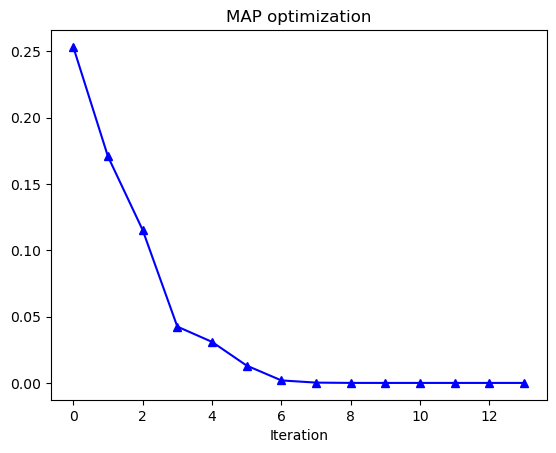

In [9]:
from scipy.optimize import minimize

# find the mode of the target
dim = 2
x_MAP = np.zeros(dim)
loss_history = []
def callback(x):
    loss = -logdensity_banana(x)
    loss_history.append(loss)
    #print(loss)

@jax.jit
def loss(x):
    return -logdensity_banana(x)
loss_grad = jax.jit(jax.grad(loss))
res = minimize(
            fun=loss,
            x0=x_MAP,
            jac=loss_grad, 
            tol=1e-10,
            callback=callback)
x_MAP_banana = res.x
hessian = jax.hessian(loss)(x_MAP)
cov_MAP_banana = np.linalg.inv(hessian)

plt.plot(loss_history, "b-^")
plt.title("MAP optimization")
plt.xlabel("Iteration")

### DAIS

In [10]:
# Run DAIS
dais = DAIS(logtarget=logdensity_banana)
mu_init = x_MAP_banana
cov_init = cov_MAP_banana
n_iter = 50
key, key_ = jr.split(key)


def run_dais(n_samples):
    return dais.run(key=key,
        n_samples=n_samples,
        n_iter=n_iter,
        mu_init=mu_init,
        cov_init=cov_init,
        ess_threshold=10.**3 / n_samples,
        c_robust=0.5,
        verbose=True)


print("Running DAIS with S = 100,000...")
dais_output_banana = run_dais(10**5)
print("Running DAIS with S = 1010...")
dais_output_banana_small_S = run_dais(1010)

Running DAIS with S = 100,000...
[00001/50] 	 eps: 0.82 	 ELBO: 0.18 	 ESS: 0.001
[00002/50] 	 eps: 1.00 	 ELBO: 0.37 	 ESS: 0.022
[00003/50] 	 eps: 1.00 	 ELBO: 0.22 	 ESS: 0.097
[00004/50] 	 eps: 1.00 	 ELBO: -0.22 	 ESS: 0.067
[00005/50] 	 eps: 1.00 	 ELBO: -0.78 	 ESS: 0.053
[00006/50] 	 eps: 1.00 	 ELBO: -1.23 	 ESS: 0.029
[00007/50] 	 eps: 0.87 	 ELBO: -2.34 	 ESS: 0.001
[00008/50] 	 eps: 1.00 	 ELBO: -3.13 	 ESS: 0.051
[00009/50] 	 eps: 1.00 	 ELBO: -3.94 	 ESS: 0.084
[00010/50] 	 eps: 1.00 	 ELBO: -4.30 	 ESS: 0.027
[00011/50] 	 eps: 1.00 	 ELBO: -6.50 	 ESS: 0.052
[00012/50] 	 eps: 1.00 	 ELBO: -4.61 	 ESS: 0.080
[00013/50] 	 eps: 0.64 	 ELBO: -5.65 	 ESS: 0.000
[00014/50] 	 eps: 1.00 	 ELBO: -8.84 	 ESS: 0.014
[00015/50] 	 eps: 1.00 	 ELBO: -10.53 	 ESS: 0.099
[00016/50] 	 eps: 1.00 	 ELBO: -5.54 	 ESS: 0.084
[00017/50] 	 eps: 1.00 	 ELBO: -4.90 	 ESS: 0.017
[00018/50] 	 eps: 0.96 	 ELBO: -5.33 	 ESS: 0.006
[00019/50] 	 eps: 1.00 	 ELBO: -7.12 	 ESS: 0.163
[00020/50] 	 eps: 1

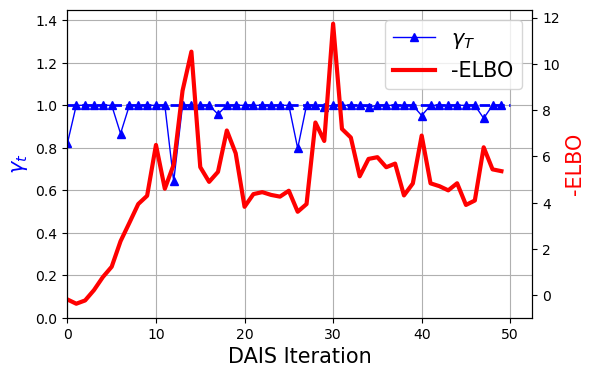

In [11]:
display_DAIS_trajectory(dais_output_banana)

### Full Covariance Variational Inference

In [12]:
# Run Double Stochastic Variational Inference
DSVI = DoubleStochastic(logtarget=logdensity_banana)
key, key_ = jr.split(key)
DSVI_output_banana = DSVI.run(
                            key=key,
                            n_samples = 1000,
                            n_iter=10_000,
                            mu_init = x_MAP_banana,
                            cov_init = cov_MAP_banana,
                            verbose=False)

In [13]:
DSVI_mu_banana = DSVI_output_banana["params"]["mu"]
DSVI_Sigma_chol = DSVI_output_banana["params"]["cov_chol"]
DSVI_Sigma_banana = DSVI_Sigma_chol @ DSVI_Sigma_chol.T

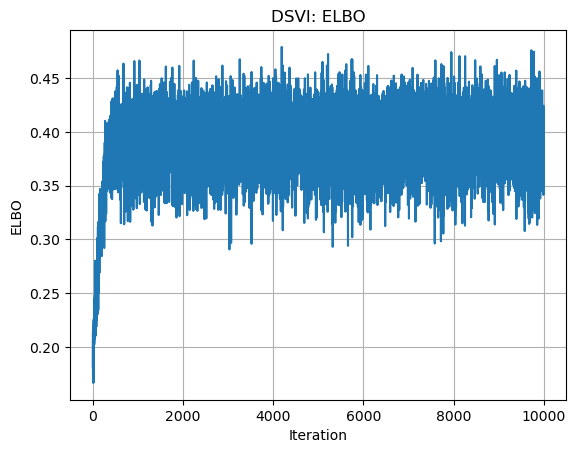

In [14]:
plt.plot(DSVI_output_banana["elbo_trace"])
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.title("DSVI: ELBO")
plt.grid()

### Adaptive Multiple Importance Sampling

In [15]:
amis = AMIS(logtarget=logdensity_banana)
key, key_ = jr.split(key)
AMIS_output_banana = amis.run(
            key=key,
            n_samples = 10_000, 
            n_iter=20,
            cov_init=cov_MAP_banana,
            mu_init=x_MAP_banana,
            family="student",
            verbose=True)
AMIS_mu_banana = AMIS_output_banana["mu"]
AMIS_Sigma_banana = AMIS_output_banana["cov"]

Iteration 1/20
Iteration 2/20
Iteration 3/20
Iteration 4/20
Iteration 5/20
Iteration 6/20
Iteration 7/20
Iteration 8/20
Iteration 9/20
Iteration 10/20
Iteration 11/20
Iteration 12/20
Iteration 13/20
Iteration 14/20
Iteration 15/20
Iteration 16/20
Iteration 17/20
Iteration 18/20
Iteration 19/20
Iteration 20/20


### Optimized Adaptive Importance Sampling (OAIS)


In [16]:
# Run OAIS
oais_full = OAIS(logtarget=logdensity_banana)
key, key_ = jr.split(key)
oais_full_output_banana = oais_full.run(
            key=key,
            n_samples = 1_000, 
            adam_lr=0.01,
            n_iter=10_000,
            cov_init=cov_MAP_banana,
            mu_init=x_MAP_banana,
            approx_type="full",
            use_jit = True,
            verbose=False)

Initial Objective: 35.41722


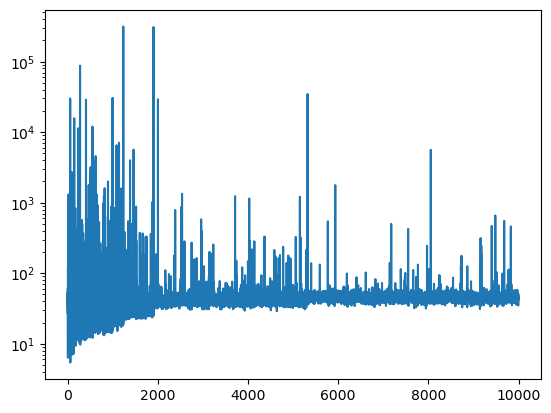

In [17]:
objective_trace = np.array(oais_full_output_banana["objective_trace"])
plt.plot(objective_trace)
plt.yscale("log")

In [18]:
OAIS_mu_banana = oais_full_output_banana["params"]["mu"]
OAIS_Sigma_chol = oais_full_output_banana["params"]["cov_chol"]
OAIS_Sigma_banana = OAIS_Sigma_chol @ OAIS_Sigma_chol.T

### Display results for Banana toy example

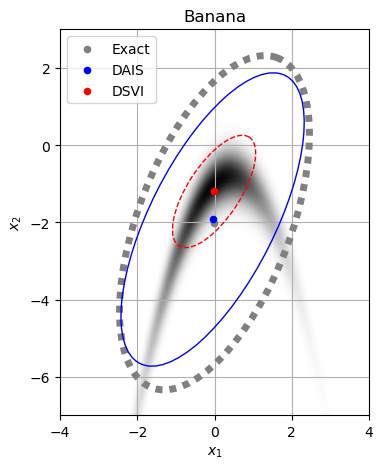

In [19]:
display_statistics(
        logdensity = logdensity_banana,
        dais_output = dais_output_banana,
        DSVI_mu = DSVI_mu_banana,
        DSVI_Sigma = DSVI_Sigma_banana,
        mu_exact = mu_exact_banana,
        Sigma_exact = Sigma_exact_banana,
        xlims = (-4, 4),
        ylims = (-7, 3)
        )
plt.title("Banana")

# export pdf with tight layout
plt.tight_layout()
plt.savefig("banana.pdf", bbox_inches='tight')

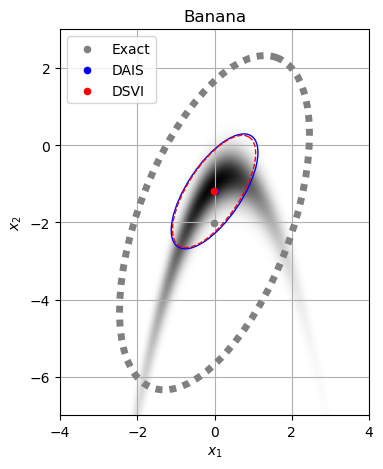

In [20]:
display_statistics(
        logdensity = logdensity_banana,
        dais_output = dais_output_banana_small_S,
        DSVI_mu = DSVI_mu_banana,
        DSVI_Sigma = DSVI_Sigma_banana,
        mu_exact = mu_exact_banana,
        Sigma_exact = Sigma_exact_banana,
        xlims = (-4, 4),
        ylims = (-7, 3)
        )
plt.title("Banana")

# export pdf with tight layout
plt.tight_layout()
plt.savefig("banana_small_S.pdf", bbox_inches='tight')

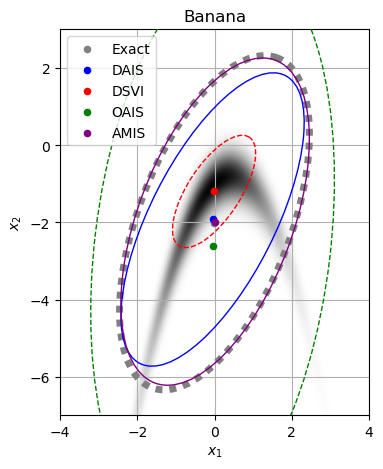

In [21]:
display_statistics(
        logdensity = logdensity_banana,
        dais_output = dais_output_banana,
        DSVI_mu = DSVI_mu_banana,
        DSVI_Sigma = DSVI_Sigma_banana,
        OAIS_mu = OAIS_mu_banana,
        OAIS_Sigma = OAIS_Sigma_banana,
        AMIS_mu = AMIS_mu_banana,
        AMIS_Sigma = AMIS_Sigma_banana,
        mu_exact = mu_exact_banana,
        Sigma_exact = Sigma_exact_banana,
        xlims = (-4, 4),
        ylims = (-7, 3)
        )
plt.title("Banana")

# export pdf
plt.tight_layout()
plt.savefig("banana_comparisons.pdf", bbox_inches='tight')

## Mixture distribution: method comparison

In [22]:
# adaptive IS with a large number of samples to get good estimates
key, key_ = jr.split(key)
n_samples = 10**6
n_iter = 5
AIS_output = basic_adaptive_IS(
                    logdensity_mixture,
                    n_samples,
                    n_iter,
                    key_)
mu_exact_mixture = AIS_output["mu"]
Sigma_exact_mixture = AIS_output["Sigma"]

Iteration 0 	 ESS_normalized = 0.082
Iteration 1 	 ESS_normalized = 0.221
Iteration 2 	 ESS_normalized = 0.220
Iteration 3 	 ESS_normalized = 0.223
Iteration 4 	 ESS_normalized = 0.224


Text(0.5, 0, 'Iteration')

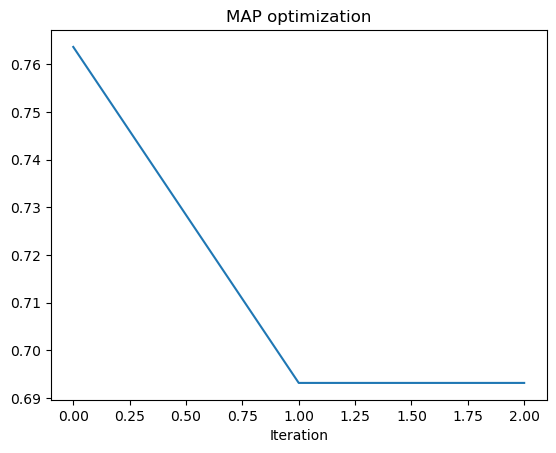

In [23]:
from scipy.optimize import minimize

# find the mode of the target
dim = 2
x_MAP = np.zeros(dim)
loss_history = []
def callback(x):
    loss = -logdensity_mixture(x)
    loss_history.append(loss)
    #print(loss)

@jax.jit
def loss(x):
    return -logdensity_mixture(x)
loss_grad = jax.jit(jax.grad(loss))
res = minimize(
            fun=loss,
            x0=x_MAP,
            jac=loss_grad, 
            tol=1e-12,
            callback=callback)
x_MAP_mixture = res.x
hessian = jax.hessian(loss)(x_MAP)
cov_MAP_mixture = np.linalg.inv(hessian)

plt.plot(loss_history)
plt.title("MAP optimization")
plt.xlabel("Iteration")

In [24]:
# Run DAIS
dais = DAIS(logtarget=logdensity_mixture)
mu_init = x_MAP_mixture
cov_init = cov_MAP_mixture
n_iter = 50
key, key_ = jr.split(key)


def run_dais(n_samples):
    return dais.run(key=key,
        n_samples=n_samples,
        n_iter=n_iter,
        mu_init=mu_init,
        cov_init=cov_init,
        ess_threshold=10.**3 / n_samples,
        c_robust=0.5,
        verbose=True)


print("Running DAIS with S = 100,000...")
dais_output_mixture = run_dais(10**5)
print("Running DAIS with S = 1010...")
dais_output_mixture_small_S = run_dais(1010)

Running DAIS with S = 100,000...
[00001/50] 	 eps: 0.82 	 ELBO: 0.73 	 ESS: 0.001
[00002/50] 	 eps: 0.97 	 ELBO: 1.01 	 ESS: 0.007
[00003/50] 	 eps: 1.00 	 ELBO: 1.04 	 ESS: 0.145
[00004/50] 	 eps: 1.00 	 ELBO: 0.93 	 ESS: 0.252
[00005/50] 	 eps: 1.00 	 ELBO: 0.81 	 ESS: 0.441
[00006/50] 	 eps: 1.00 	 ELBO: 0.77 	 ESS: 0.462
[00007/50] 	 eps: 1.00 	 ELBO: 0.74 	 ESS: 0.467
[00008/50] 	 eps: 1.00 	 ELBO: 0.71 	 ESS: 0.467
[00009/50] 	 eps: 1.00 	 ELBO: 0.71 	 ESS: 0.468
[00010/50] 	 eps: 1.00 	 ELBO: 0.71 	 ESS: 0.466
[00011/50] 	 eps: 1.00 	 ELBO: 0.70 	 ESS: 0.471
[00012/50] 	 eps: 1.00 	 ELBO: 0.69 	 ESS: 0.469
[00013/50] 	 eps: 1.00 	 ELBO: 0.70 	 ESS: 0.467
[00014/50] 	 eps: 1.00 	 ELBO: 0.73 	 ESS: 0.472
[00015/50] 	 eps: 1.00 	 ELBO: 0.72 	 ESS: 0.470
[00016/50] 	 eps: 1.00 	 ELBO: 0.72 	 ESS: 0.469
[00017/50] 	 eps: 1.00 	 ELBO: 0.70 	 ESS: 0.467
[00018/50] 	 eps: 1.00 	 ELBO: 0.71 	 ESS: 0.469
[00019/50] 	 eps: 1.00 	 ELBO: 0.71 	 ESS: 0.470
[00020/50] 	 eps: 1.00 	 ELBO: 0.70 

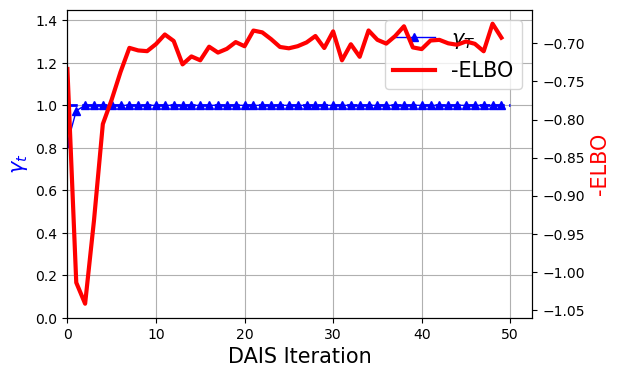

In [25]:
display_DAIS_trajectory(dais_output_mixture)

In [26]:
# Run Double Stochastic Variational Inference
DSVI = DoubleStochastic(logtarget=logdensity_mixture)
key, key_ = jr.split(key)
DSVI_output_mixture = DSVI.run(
                        key=key,
                        n_samples = 1000,
                        n_iter=10_000,
                        mu_init = x_MAP_mixture,
                        cov_init = cov_MAP_mixture,
                        verbose=False)

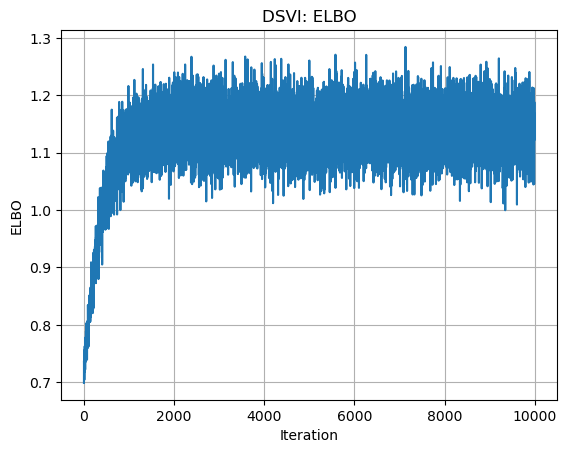

In [27]:
plt.plot(DSVI_output_mixture["elbo_trace"])
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.title("DSVI: ELBO")
plt.grid()

In [28]:
DSVI_mu_mixture = DSVI_output_mixture["params"]["mu"]
DSVI_Sigma_chol = DSVI_output_mixture["params"]["cov_chol"]
DSVI_Sigma_mixture = DSVI_Sigma_chol @ DSVI_Sigma_chol.T

In [29]:
# Run OAIS
oais_full = OAIS(logtarget=logdensity_mixture)
key, key_ = jr.split(key)
oais_full_output_mixture = oais_full.run(
            key=key,
            n_samples = 1_000, 
            adam_lr=0.01,
            n_iter=50_000,
            cov_init=cov_MAP_mixture,
            mu_init=x_MAP_mixture,
            approx_type="full",
            use_jit = True,
            verbose=False)

Initial Objective: 2746.31152


In [30]:
OAIS_mu_mixture = oais_full_output_mixture["params"]["mu"]
OAIS_Sigma_chol = oais_full_output_mixture["params"]["cov_chol"]
OAIS_Sigma_mixture = OAIS_Sigma_chol @ OAIS_Sigma_chol.T

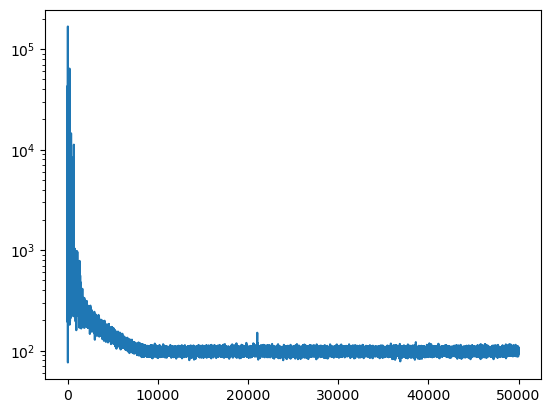

In [31]:
objective_trace = np.array(oais_full_output_mixture["objective_trace"])
plt.plot(objective_trace)
plt.yscale("log")

In [32]:
amis = AMIS(logtarget=logdensity_mixture)
key, key_ = jr.split(key)
AMIS_output_mixture = amis.run(
            key=key,
            n_samples = 10_000, 
            n_iter=20,
            cov_init=cov_MAP_mixture,
            mu_init=x_MAP_mixture,
            verbose=True)
AMIS_mu_mixture = AMIS_output_mixture["mu"]
AMIS_Sigma_mixture = AMIS_output_mixture["cov"]

Iteration 1/20
Iteration 2/20
Iteration 3/20
Iteration 4/20
Iteration 5/20
Iteration 6/20
Iteration 7/20
Iteration 8/20
Iteration 9/20
Iteration 10/20
Iteration 11/20
Iteration 12/20
Iteration 13/20
Iteration 14/20
Iteration 15/20
Iteration 16/20
Iteration 17/20
Iteration 18/20
Iteration 19/20
Iteration 20/20


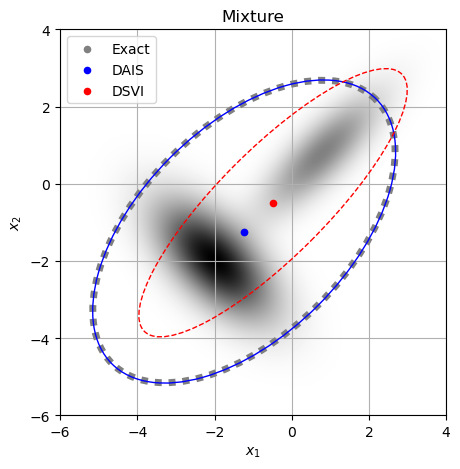

In [33]:
display_statistics(
        logdensity = logdensity_mixture,
        dais_output = dais_output_mixture,
        DSVI_mu = DSVI_mu_mixture,
        DSVI_Sigma = DSVI_Sigma_mixture,
        mu_exact = mu_exact_mixture,
        Sigma_exact = Sigma_exact_mixture,
        xlims = (-6, 4),
        ylims = (-6, 4)
        )
plt.title("Mixture")

# export pdf
plt.tight_layout()
plt.savefig("mixture.pdf", bbox_inches='tight')

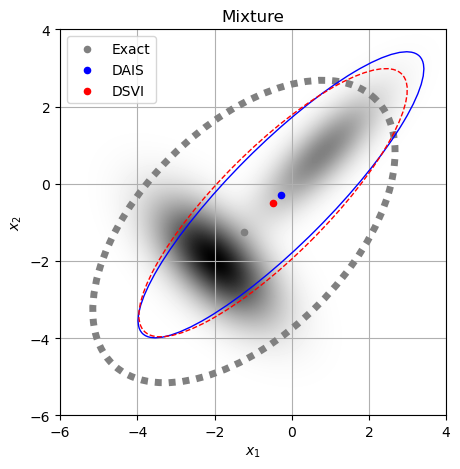

In [34]:
display_statistics(
        logdensity = logdensity_mixture,
        dais_output = dais_output_mixture_small_S,
        DSVI_mu = DSVI_mu_mixture,
        DSVI_Sigma = DSVI_Sigma_mixture,
        mu_exact = mu_exact_mixture,
        Sigma_exact = Sigma_exact_mixture,
        xlims = (-6, 4),
        ylims = (-6, 4)
        )
plt.title("Mixture")

# export pdf
plt.tight_layout()
plt.savefig("mixture_small_S.pdf", bbox_inches='tight')

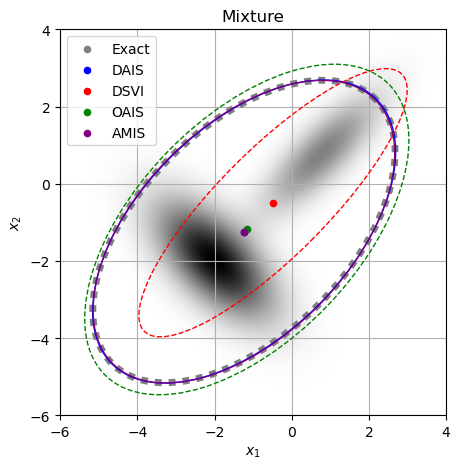

In [35]:
display_statistics(
        logdensity = logdensity_mixture,
        dais_output = dais_output_mixture,
        DSVI_mu = DSVI_mu_mixture,
        DSVI_Sigma = DSVI_Sigma_mixture,
        OAIS_mu = OAIS_mu_mixture,
        OAIS_Sigma = OAIS_Sigma_mixture,
        AMIS_mu = AMIS_mu_mixture,
        AMIS_Sigma = AMIS_Sigma_mixture,
        mu_exact = mu_exact_mixture,
        Sigma_exact = Sigma_exact_mixture,
        xlims = (-6, 4),
        ylims = (-6, 4)
        )
plt.title("Mixture")

# export with minimal white space on the sides
plt.tight_layout()
plt.savefig("mixture_comparisons.pdf", bbox_inches='tight')